# HM5: Build a Supervised Autoencoder.

### Name: Saeid Hosseinipoor



PCA and the standard autoencoder are unsupervised dimensionality reduction methods, and their learned features are not discriminative. If you build a classifier upon the low-dimenional features extracted by PCA and autoencoder, you will find the classification accuracy very poor.

Linear discriminant analysis (LDA) is a traditionally supervised dimensionality reduction method for learning low-dimensional features which are highly discriminative. Likewise, can we extend autoencoder to supervised leanring?



**You are required to build and train a supervised autoencoder look like the following.** You are required to add other layers properly to alleviate overfitting.


![Network Structure](https://github.com/wangshusen/CS583A-2019Spring/blob/master/homework/HM5/supervised_ae.png?raw=true "NetworkStructure")


## 0. You will do the following:

1. Read and run my code to train a standard dense autoencoder.

2. Build and train a supervised autoencoder, visual the low-dim features and the reconstructions, and evaluate whether the learned low-dim features are discriminative.
    
3. Convert the .IPYNB file to .HTML file.

    * The HTML file must contain the code and the output after execution.
    
    
    
4. Upload this .HTML file to your Github repo.

4. Submit the link to this .HTML file to Canvas.

    * Example: https://github.com/wangshusen/CS583A-2019Spring/blob/master/homework/HM5/sae.html


## 1. Data preparation

### 1.1. Load data


In [1]:
from keras.datasets import mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train.reshape(60000, 28*28).astype('float32') / 255.
x_test = x_test.reshape(10000, 28*28).astype('float32') / 255.

print('Shape of x_train: ' + str(x_train.shape)) 
print('Shape of x_test: ' + str(x_test.shape))
print('Shape of y_train: ' + str(y_train.shape))
print('Shape of y_test: ' + str(y_test.shape))

Using TensorFlow backend.


Shape of x_train: (60000, 784)
Shape of x_test: (10000, 784)
Shape of y_train: (60000,)
Shape of y_test: (10000,)


### 1.2. One-hot encode the labels

In the input, a label is a scalar in $\{0, 1, \cdots , 9\}$. One-hot encode transform such a scalar to a $10$-dim vector. E.g., a scalar ```y_train[j]=3``` is transformed to the vector ```y_train_vec[j]=[0, 0, 0, 1, 0, 0, 0, 0, 0, 0]```.

1. Define a function ```to_one_hot``` that transforms an $n\times 1$ array to a $n\times 10$ matrix.

2. Apply the function to ```y_train``` and ```y_test```.

In [2]:
import numpy

def to_one_hot(y, num_class=10):
    results = numpy.zeros((len(y), num_class))
    for i, label in enumerate(y):
        results[i, label] = 1.
    return results

y_train_vec = to_one_hot(y_train)
y_test_vec = to_one_hot(y_test)

print('Shape of y_train_vec: ' + str(y_train_vec.shape))
print('Shape of y_test_vec: ' + str(y_test_vec.shape))

print(y_train[0])
print(y_train_vec[0])

Shape of y_train_vec: (60000, 10)
Shape of y_test_vec: (10000, 10)
5
[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]


### 1.3. Randomly partition the training set to training and validation sets

Randomly partition the 60K training samples to 2 sets:
* a training set containing 50K samples
* a validation set containing 10K samples


In [3]:
rand_indices = numpy.random.permutation(60000)
train_indices = rand_indices[0:50000]
valid_indices = rand_indices[50000:60000]

x_val = x_train[valid_indices, :]
y_val = y_train_vec[valid_indices, :]

x_tr = x_train[train_indices, :]
y_tr = y_train_vec[train_indices, :]

print('Shape of x_tr: ' + str(x_tr.shape))
print('Shape of y_tr: ' + str(y_tr.shape))
print('Shape of x_val: ' + str(x_val.shape))
print('Shape of y_val: ' + str(y_val.shape))

Shape of x_tr: (50000, 784)
Shape of y_tr: (50000, 10)
Shape of x_val: (10000, 784)
Shape of y_val: (10000, 10)


## 2. Build an unsupervised  autoencoder and tune its hyper-parameters

1. Build a dense autoencoder model
2. Use the validation data to tune the hyper-parameters (e.g., network structure, and optimization algorithm)
    * Do NOT use test data for hyper-parameter tuning!!!
    
3. Try to achieve a validation loss as low as possible.
4. Evaluate the model on the test set.
5. Visualize the low-dim features and reconstructions.

### 2.1. Build the model

In [4]:
from keras.layers import Dense, Input, BatchNormalization, Dropout, Activation
from keras import models

input_img = Input(shape=(784,), name='input_img')

encode1_den = Dense(256, name='encode1_den')(input_img)
encode1_bn = BatchNormalization(name='encode1_bn')(encode1_den)
encode1 = Activation('relu', name='encode1')(encode1_bn)

encode2_drop = Dropout(0.5, name='encode2_drop')(encode1)
encode2_den = Dense(128, name='encode2_den')(encode2_drop)
encode2_bn = BatchNormalization(name='encode2_bn')(encode2_den)
encode2 = Activation('relu', name='encode2')(encode2_bn)

# encode3_drop = Dropout(0.5, name='encode3_drop')(encode2)
encode3_den = Dense(32, name='encode3_den')(encode2)
encode3_bn = BatchNormalization(name='encode3_bn')(encode3_den)
encode3 = Activation('relu', name='encode3')(encode3_bn)

# encode4_drop = Dropout(0.5, name='encode4_drop')(encode3)
encode4_den = Dense(8, name='encode4_den')(encode3)
encode4_bn = BatchNormalization(name='encode4_bn')(encode4_den)
encode4 = Activation('relu', name='encode4')(encode4_bn)

bottleneck = Dense(2, activation='relu', name='bottleneck')(encode4)

# encode4_drop = Dropout(0.5, name='encode4_drop')(encode3)
decode1_den = Dense(8, name='decode1_den')(bottleneck)
decode1_bn = BatchNormalization(name='decode1_bn')(decode1_den)
decode1 = Activation('relu', name='decode1')(decode1_bn)

# encode3_drop = Dropout(0.5, name='encode3_drop')(encode2)
decode2_den = Dense(32, name='decode2_den')(decode1)
decode2_bn = BatchNormalization(name='decode2_bn')(decode2_den)
decode2 = Activation('relu', name='decode2')(decode2_bn)

# decode3_drop = Dropout(0.5, name='decode3_drop')(decode2)
decode3_den = Dense(128, name='decode3_den')(decode2)
decode3_bn = BatchNormalization(name='decode3_bn')(decode3_den)
decode3 = Activation('relu', name='decode3')(decode3_bn)

# decode4_drop = Dropout(0.5, name='decode4_drop')(decode3)
decode4_den = Dense(256, name='decode4_den')(decode3)
decode4_bn = BatchNormalization(name='decode4_bn')(decode4_den)
decode4 = Activation('relu', name='decode4')(decode4_bn)

decode5_drop = Dropout(0.5, name='decode5_drop')(decode4)
decode5_den = Dense(784, name='decode5_den')(decode5_drop)
decode5_bn = BatchNormalization(name='decode5_bn')(decode5_den)
decode5 = Activation('relu', name='decode5')(decode5_bn)

ae = models.Model(input_img, decode5)

ae.summary()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_img (InputLayer)       (None, 784)               0         
_________________________________________________________________
encode1_den (Dense)          (None, 256)               200960    
_________________________________________________________________
encode1_bn (BatchNormalizati (None, 256)               1024      
_________________________________________________________________
encode1 (Activation)         (None, 256)               0         
_________________________________________________________________
encode2_drop (Dropout)       (None, 256)               0         
_________________________________________________________________
encode2_den (Dense)  

In [5]:
# print the network structure to a PDF file

from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot, plot_model

SVG(model_to_dot(ae, show_shapes=False).create(prog='dot', format='svg'))

plot_model(
    model=ae, show_shapes=False,
    to_file='unsupervised_ae.pdf'
)

# you can find the file "unsupervised_ae.pdf" in the current directory.

### 2.2. Train the model and tune the hyper-parameters

In [6]:
from keras import optimizers

learning_rate = 7E-3 # to be tuned!

ae.compile(loss='mean_squared_error',
           optimizer=optimizers.RMSprop(lr=learning_rate))

In [7]:
history = ae.fit(x_tr, x_tr, 
                 batch_size=128, 
                 epochs=100, 
                 validation_data=(x_val, x_val))

Instructions for updating:
Use tf.cast instead.
Train on 50000 samples, validate on 10000 samples
Epoch 1/100
50000/50000 [==============================] - 5s 104us/step - loss: 0.0602 - val_loss: 0.0527
Epoch 2/100
50000/50000 [==============================] - 4s 71us/step - loss: 0.0500 - val_loss: 0.0464
Epoch 3/100
50000/50000 [==============================] - 4s 71us/step - loss: 0.0488 - val_loss: 0.0468
Epoch 4/100
50000/50000 [==============================] - 4s 72us/step - loss: 0.0472 - val_loss: 0.0473
Epoch 5/100
50000/50000 [==============================] - 4s 71us/step - loss: 0.0458 - val_loss: 0.0450
Epoch 6/100
50000/50000 [==============================] - 4s 70us/step - loss: 0.0450 - val_loss: 0.0462
Epoch 7/100
50000/50000 [==============================] - 4s 70us/step - loss: 0.0447 - val_loss: 0.0432
Epoch 8/100
50000/50000 [==============================] - 3s 67us/step - loss: 0.0444 - val_loss: 0.0424
Epoch 9/100
50000/50000 [============================

50000/50000 [==============================] - 4s 70us/step - loss: 0.0416 - val_loss: 0.0385
Epoch 75/100
50000/50000 [==============================] - 3s 70us/step - loss: 0.0418 - val_loss: 0.0388
Epoch 76/100
50000/50000 [==============================] - 4s 71us/step - loss: 0.0418 - val_loss: 0.0387
Epoch 77/100
50000/50000 [==============================] - 3s 70us/step - loss: 0.0419 - val_loss: 0.0387
Epoch 78/100
50000/50000 [==============================] - 4s 71us/step - loss: 0.0418 - val_loss: 0.0391
Epoch 79/100
50000/50000 [==============================] - 3s 69us/step - loss: 0.0418 - val_loss: 0.0389
Epoch 80/100
50000/50000 [==============================] - 3s 69us/step - loss: 0.0419 - val_loss: 0.0391
Epoch 81/100
50000/50000 [==============================] - 4s 70us/step - loss: 0.0419 - val_loss: 0.0390
Epoch 82/100
50000/50000 [==============================] - 4s 71us/step - loss: 0.0419 - val_loss: 0.0389
Epoch 83/100
50000/50000 [========================

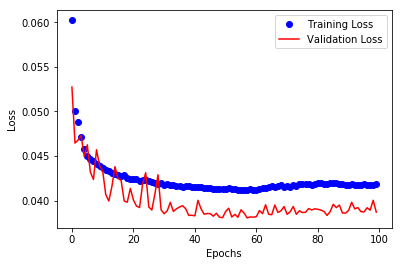

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.plot(epochs, loss, 'bo', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

### 2.3. Visualize the reconstructed test images

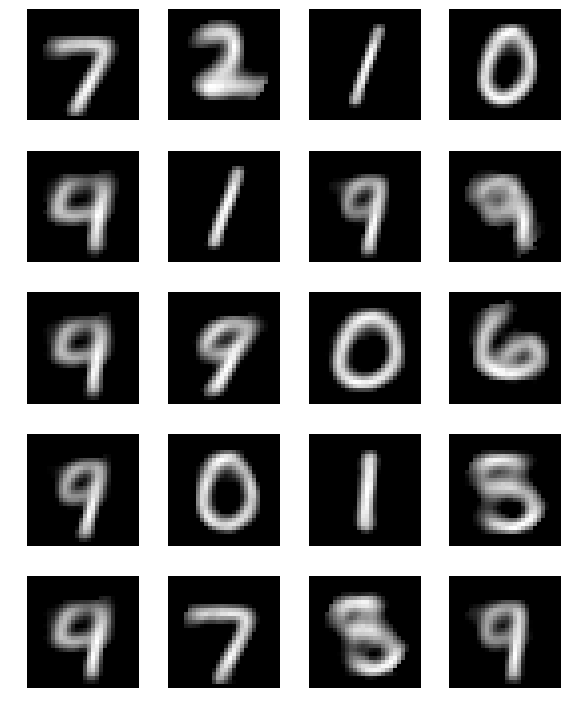

In [9]:
ae_output = ae.predict(x_test).reshape((10000, 28, 28))

ROW = 5
COLUMN = 4

x = ae_output
fname = 'reconstruct_ae.pdf'

fig, axes = plt.subplots(nrows=ROW, ncols=COLUMN, figsize=(8, 10))
for ax, i in zip(axes.flat, numpy.arange(ROW*COLUMN)):
    image = x[i].reshape(28, 28)
    ax.imshow(image, cmap='gray')
    ax.axis('off')

plt.tight_layout()
plt.savefig(fname)
plt.show()

### 2.4. Evaluate the model on the test set

Do NOT used the test set until now. Make sure that your model parameters and hyper-parameters are independent of the test set.

In [10]:
loss = ae.evaluate(x_test, x_test)
print('loss = ' + str(loss))

10000/10000 [==============================] - 0s 47us/step
loss = 0.03859238778948784


### 2.5. Visualize the low-dimensional features

In [11]:
# build the encoder network
ae_encoder = models.Model(input_img, bottleneck)
ae_encoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_img (InputLayer)       (None, 784)               0         
_________________________________________________________________
encode1_den (Dense)          (None, 256)               200960    
_________________________________________________________________
encode1_bn (BatchNormalizati (None, 256)               1024      
_________________________________________________________________
encode1 (Activation)         (None, 256)               0         
_________________________________________________________________
encode2_drop (Dropout)       (None, 256)               0         
_________________________________________________________________
encode2_den (Dense)          (None, 128)               32896     
_________________________________________________________________
encode2_bn (BatchNormalizati (None, 128)               512       
__________

In [12]:
# extract low-dimensional features from the test data
encoded_test = ae_encoder.predict(x_test)
print('Shape of encoded_test: ' + str(encoded_test.shape))

Shape of encoded_test: (10000, 2)


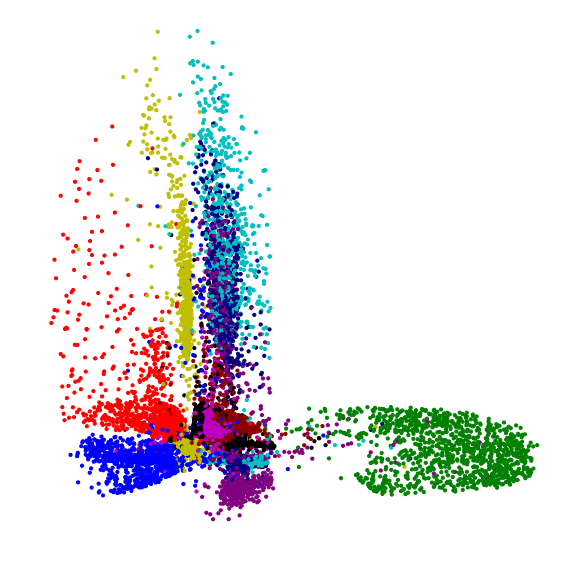

In [13]:
colors = numpy.array(['r', 'g', 'b', 'm', 'c', 'k', 'y', 'purple', 'darkred', 'navy'])
colors_test = colors[y_test]


import matplotlib.pyplot as plt
%matplotlib inline

fig = plt.figure(figsize=(8, 8))
plt.scatter(encoded_test[:, 0], encoded_test[:, 1], s=10, c=colors_test, edgecolors=colors_test)
plt.axis('off')
plt.tight_layout()
fname = 'ae_code.pdf'
plt.savefig(fname)

#### Remark:

Judging from the visualization, the low-dim features seems not discriminative, as 2D features from different classes are mixed. Let quantatively find out whether they are discriminative.

## 3. Are the learned low-dim features discriminative?

To find the answer, lets train a classifier on the training set (the extracted 2-dim features) and evaluation on the test set.

In [14]:
# extract the 2D features from the training, validation, and test samples
f_tr = ae_encoder.predict(x_tr)
f_val = ae_encoder.predict(x_val)
f_te = ae_encoder.predict(x_test)

print('Shape of f_tr: ' + str(f_tr.shape))
print('Shape of f_te: ' + str(f_te.shape))

Shape of f_tr: (50000, 2)
Shape of f_te: (10000, 2)


In [15]:
from keras.layers import Dense, Input
from keras import models

input_feat = Input(shape=(2,))

hidden1 = Dense(128, activation='relu')(input_feat)
hidden2 = Dense(128, activation='relu')(hidden1)
output = Dense(10, activation='softmax')(hidden2)

classifier = models.Model(input_feat, output)

classifier.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 2)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               384       
_________________________________________________________________
dense_2 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_3 (Dense)              (None, 10)                1290      
Total params: 18,186
Trainable params: 18,186
Non-trainable params: 0
_________________________________________________________________


In [16]:
classifier.compile(loss='categorical_crossentropy',
                  optimizer=optimizers.RMSprop(lr=1E-4),
                  metrics=['acc'])

history = classifier.fit(f_tr, y_tr, 
                        batch_size=32, 
                        epochs=30, 
                        validation_data=(f_val, y_val))

Train on 50000 samples, validate on 10000 samples
Epoch 1/30
50000/50000 [==============================] - 2s 37us/step - loss: 1.8165 - acc: 0.3152 - val_loss: 1.6693 - val_acc: 0.3551
Epoch 2/30
50000/50000 [==============================] - 1s 29us/step - loss: 1.6115 - acc: 0.3881 - val_loss: 1.5543 - val_acc: 0.4421
Epoch 3/30
50000/50000 [==============================] - 1s 29us/step - loss: 1.5016 - acc: 0.4528 - val_loss: 1.4367 - val_acc: 0.4827
Epoch 4/30
50000/50000 [==============================] - 1s 29us/step - loss: 1.3770 - acc: 0.5307 - val_loss: 1.3065 - val_acc: 0.5521
Epoch 5/30
50000/50000 [==============================] - 1s 28us/step - loss: 1.2619 - acc: 0.5712 - val_loss: 1.2080 - val_acc: 0.6022
Epoch 6/30
50000/50000 [==============================] - 1s 28us/step - loss: 1.1816 - acc: 0.6050 - val_loss: 1.1425 - val_acc: 0.6106
Epoch 7/30
50000/50000 [==============================] - 1s 28us/step - loss: 1.1256 - acc: 0.6378 - val_loss: 1.0869 - val_acc

### Conclusion

Using the 2D features, the validation accuracy is 60~70%. Recall that using the original data, the accuracy is about 98%. Obviously, the 2D features are not very discriminative.

We are going to build a supervised autoencode model for learning low-dimensional discriminative features.

## 4. Build a supervised autoencoder model


**You are required to build and train a supervised autoencoder look like the following.** (Not necessary the same.) You are required to add other layers properly to alleviate overfitting.


![Network Structure](https://github.com/wangshusen/CS583A-2019Spring/blob/master/homework/HM5/supervised_ae.png?raw=true "NetworkStructure")


### 4.1. Build the network

In [17]:
# build the supervised autoencoder network
from keras.layers import Dense, Input
from keras import models

input_img = Input(shape=(784,), name='input_img')

# encoder network
encode1_den = Dense(256, name='encode1_den')(input_img)
encode1_bn = BatchNormalization(name='encode1_bn')(encode1_den)
encode1 = Activation('relu', name='encode1')(encode1_bn)

encode2_drop = Dropout(0.5, name='encode2_drop')(encode1)
encode2_den = Dense(128, name='encode2_den')(encode2_drop)
encode2_bn = BatchNormalization(name='encode2_bn')(encode2_den)
encode2 = Activation('relu', name='encode2')(encode2_bn)

encode3_den = Dense(32, name='encode3_den')(encode2)
encode3_bn = BatchNormalization(name='encode3_bn')(encode3_den)
encode3 = Activation('relu', name='encode3')(encode3_bn)

encode4_den = Dense(8, name='encode4_den')(encode3)
encode4_bn = BatchNormalization(name='encode4_bn')(encode4_den)
encode4 = Activation('relu', name='encode4')(encode4_bn)

# The width of the bottleneck layer must be exactly 2.
bottleneck = Dense(2, activation='relu', name='bottleneck')(encode4)

# decoder network
decode1_den = Dense(8, name='decode1_den')(bottleneck)
decode1_bn = BatchNormalization(name='decode1_bn')(decode1_den)
decode1 = Activation('relu', name='decode1')(decode1_bn)

decode2_den = Dense(32, name='decode2_den')(decode1)
decode2_bn = BatchNormalization(name='decode2_bn')(decode2_den)
decode2 = Activation('relu', name='decode2')(decode2_bn)

decode3_den = Dense(128, name='decode3_den')(decode2)
decode3_bn = BatchNormalization(name='decode3_bn')(decode3_den)
decode3 = Activation('relu', name='decode3')(decode3_bn)

decode4_den = Dense(256, name='decode4_den')(decode3)
decode4_bn = BatchNormalization(name='decode4_bn')(decode4_den)
decode4 = Activation('relu', name='decode4')(decode4_bn)

decode5_drop = Dropout(0.5, name='decode5_drop')(decode4)
decode5_den = Dense(784, name='decode5_den')(decode5_drop)
decode5_bn = BatchNormalization(name='decode5_bn')(decode5_den)
decode5 = Activation('relu', name='decode5')(decode5_bn)

# build a classifier upon the bottleneck layer
# input_feat = Input(shape=(2,))
hidden1 = Dense(128, name='hidden1', activation='relu')(bottleneck)
hidden2 = Dense(128, name='hidden2', activation='relu')(hidden1)
classifier3 = Dense(10, name='classifier3', activation='softmax')(hidden2)

# encode1 = <add a dense layer taking input_img as input>
# <Add more layers...>


# bottleneck = <the output of encoder network>

# decode1 = <add a dense layer taking bottleneck as input>
# <Add more layers...>
# decode4 = <the output of decoder network>


# classifier1 = <add a dense layer taking bottleneck as input>
# <Add more dense layers and regularizations...>
# classifier3 = <the output of classifier network>

In [18]:
# connect the input and the two outputs
sae = models.Model(input_img, [decode5, classifier3])

sae.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_img (InputLayer)          (None, 784)          0                                            
__________________________________________________________________________________________________
encode1_den (Dense)             (None, 256)          200960      input_img[0][0]                  
__________________________________________________________________________________________________
encode1_bn (BatchNormalization) (None, 256)          1024        encode1_den[0][0]                
__________________________________________________________________________________________________
encode1 (Activation)            (None, 256)          0           encode1_bn[0][0]                 
__________________________________________________________________________________________________
encode2_dr

In [19]:
# print the network structure to a PDF file

from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot, plot_model

SVG(model_to_dot(sae, show_shapes=False).create(prog='dot', format='svg'))

plot_model(
    model=sae, show_shapes=False,
    to_file='supervised_ae.pdf'
)

# you can find the file "supervised_ae.pdf" in the current directory.

### 4.2. Train the new model and tune the hyper-parameters

The new model has multiple output. Thus we specify **multiple** loss functions and their weights. 

In [20]:
from keras import optimizers

sae.compile(loss=['mean_squared_error', 'categorical_crossentropy'],
            loss_weights=[0.15, 0.85], # to be tuned
            optimizer=optimizers.RMSprop(lr=1E-3))

history = sae.fit(x_tr, [x_tr, y_tr], 
                  batch_size=32, 
                  epochs=100, 
                  validation_data=(x_val, [x_val, y_val]))

Train on 50000 samples, validate on 10000 samples
Epoch 1/100
50000/50000 [==============================] - 12s 247us/step - loss: 0.8465 - decode5_loss: 0.0689 - classifier3_loss: 0.9837 - val_loss: 0.3300 - val_decode5_loss: 0.0579 - val_classifier3_loss: 0.3780
Epoch 2/100
50000/50000 [==============================] - 10s 209us/step - loss: 0.4742 - decode5_loss: 0.0608 - classifier3_loss: 0.5471 - val_loss: 0.2350 - val_decode5_loss: 0.0574 - val_classifier3_loss: 0.2663
Epoch 3/100
50000/50000 [==============================] - 10s 209us/step - loss: 0.3911 - decode5_loss: 0.0598 - classifier3_loss: 0.4496 - val_loss: 0.1903 - val_decode5_loss: 0.0583 - val_classifier3_loss: 0.2136
Epoch 4/100
50000/50000 [==============================] - 11s 210us/step - loss: 0.3489 - decode5_loss: 0.0595 - classifier3_loss: 0.4000 - val_loss: 0.1759 - val_decode5_loss: 0.0569 - val_classifier3_loss: 0.1969
Epoch 5/100
50000/50000 [==============================] - 10s 207us/step - loss: 0.32

50000/50000 [==============================] - 10s 208us/step - loss: 0.1984 - decode5_loss: 0.0539 - classifier3_loss: 0.2239 - val_loss: 0.1097 - val_decode5_loss: 0.0522 - val_classifier3_loss: 0.1199
Epoch 39/100
50000/50000 [==============================] - 10s 206us/step - loss: 0.1995 - decode5_loss: 0.0541 - classifier3_loss: 0.2252 - val_loss: 0.1115 - val_decode5_loss: 0.0525 - val_classifier3_loss: 0.1219
Epoch 40/100
50000/50000 [==============================] - 10s 209us/step - loss: 0.2025 - decode5_loss: 0.0540 - classifier3_loss: 0.2287 - val_loss: 0.1089 - val_decode5_loss: 0.0524 - val_classifier3_loss: 0.1189
Epoch 41/100
50000/50000 [==============================] - 11s 211us/step - loss: 0.2066 - decode5_loss: 0.0540 - classifier3_loss: 0.2335 - val_loss: 0.1078 - val_decode5_loss: 0.0523 - val_classifier3_loss: 0.1175
Epoch 42/100
50000/50000 [==============================] - 11s 212us/step - loss: 0.1965 - decode5_loss: 0.0540 - classifier3_loss: 0.2216 - val

Epoch 76/100
50000/50000 [==============================] - 10s 203us/step - loss: 0.1997 - decode5_loss: 0.0539 - classifier3_loss: 0.2254 - val_loss: 0.1156 - val_decode5_loss: 0.0524 - val_classifier3_loss: 0.1267
Epoch 77/100
50000/50000 [==============================] - 10s 202us/step - loss: 0.2000 - decode5_loss: 0.0539 - classifier3_loss: 0.2258 - val_loss: 0.1082 - val_decode5_loss: 0.0527 - val_classifier3_loss: 0.1180
Epoch 78/100
50000/50000 [==============================] - 10s 205us/step - loss: 0.2077 - decode5_loss: 0.0540 - classifier3_loss: 0.2348 - val_loss: 0.1469 - val_decode5_loss: 0.0528 - val_classifier3_loss: 0.1635
Epoch 79/100
50000/50000 [==============================] - 11s 214us/step - loss: 0.2022 - decode5_loss: 0.0539 - classifier3_loss: 0.2284 - val_loss: 0.1355 - val_decode5_loss: 0.0529 - val_classifier3_loss: 0.1500
Epoch 80/100
50000/50000 [==============================] - 11s 210us/step - loss: 0.2017 - decode5_loss: 0.0539 - classifier3_loss:

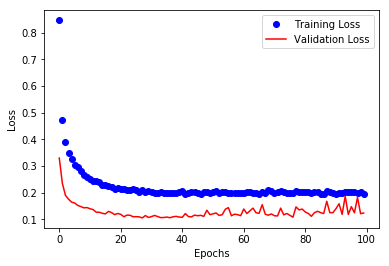

In [21]:
import matplotlib.pyplot as plt
%matplotlib inline

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.plot(epochs, loss, 'bo', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

### Question

Do you think overfitting is happening? If yes, what can you do? Please make necessary changes to the supervised autoencoder network structure.

**Failing to add proper regularization will lose 1~2 scores.**

### 4.3. Visualize the reconstructed test images

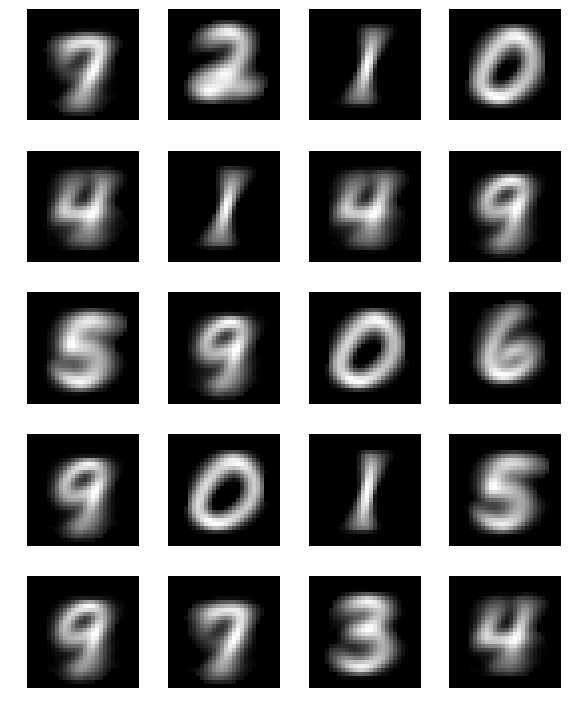

In [22]:
sae_output = sae.predict(x_test)[0].reshape((10000, 28, 28))

ROW = 5
COLUMN = 4

x = sae_output
fname = 'reconstruct_sae.pdf'

fig, axes = plt.subplots(nrows=ROW, ncols=COLUMN, figsize=(8, 10))
for ax, i in zip(axes.flat, numpy.arange(ROW*COLUMN)):
    image = x[i].reshape(28, 28)
    ax.imshow(image, cmap='gray')
    ax.axis('off')

plt.tight_layout()
plt.savefig(fname)
plt.show()

### 4.4. Visualize the low-dimensional features

In [23]:
# build the encoder model
sae_encoder = models.Model(input_img, bottleneck)
sae_encoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_img (InputLayer)       (None, 784)               0         
_________________________________________________________________
encode1_den (Dense)          (None, 256)               200960    
_________________________________________________________________
encode1_bn (BatchNormalizati (None, 256)               1024      
_________________________________________________________________
encode1 (Activation)         (None, 256)               0         
_________________________________________________________________
encode2_drop (Dropout)       (None, 256)               0         
_________________________________________________________________
encode2_den (Dense)          (None, 128)               32896     
_________________________________________________________________
encode2_bn (BatchNormalizati (None, 128)               512       
__________

Shape of encoded_test: (10000, 2)


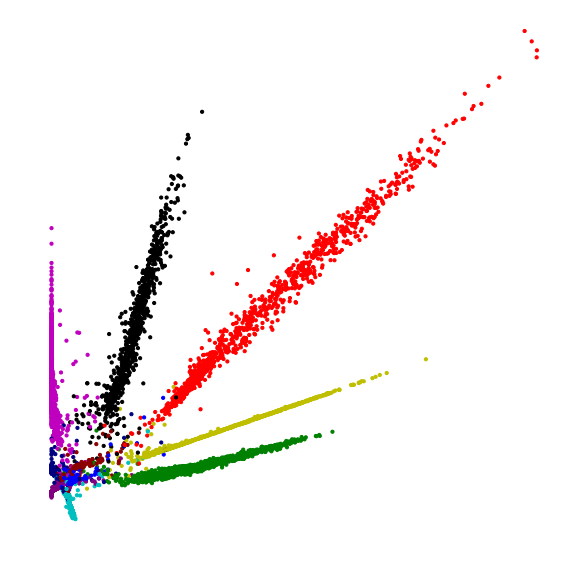

In [24]:
# extract test features
encoded_test = sae_encoder.predict(x_test)
print('Shape of encoded_test: ' + str(encoded_test.shape))

colors = numpy.array(['r', 'g', 'b', 'm', 'c', 'k', 'y', 'purple', 'darkred', 'navy'])
colors_test = colors[y_test]


import matplotlib.pyplot as plt
%matplotlib inline

fig = plt.figure(figsize=(8, 8))
plt.scatter(encoded_test[:, 0], encoded_test[:, 1], s=10, c=colors_test, edgecolors=colors_test)
plt.axis('off')
plt.tight_layout()
fname = 'sae_code.pdf'
plt.savefig(fname)

### 4.5. Are the learned low-dim features discriminative?

To find the answer, lets train a classifier on the training set (the extracted 2-dim features) and evaluation on the test set.


In [25]:
# extract 2D features from the training, validation, and test samples
f_tr = sae_encoder.predict(x_tr)
f_val = sae_encoder.predict(x_val)
f_te = sae_encoder.predict(x_test)

In [26]:
# build a classifier which takes the 2D features as input
from keras.layers import Dense, Input
from keras import models

input_feat = Input(shape=(2,))

hidden1 = Dense(128, name='hidden1', activation='relu')(input_feat)
hidden2 = Dense(128, name='hidden2', activation='relu')(hidden1)
output = Dense(10, name='output', activation='softmax')(hidden2)


# <build a classifier which takes input_feat as input>
# output = <output of the classifier network>

classifier = models.Model(input_feat, output)

classifier.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 2)                 0         
_________________________________________________________________
hidden1 (Dense)              (None, 128)               384       
_________________________________________________________________
hidden2 (Dense)              (None, 128)               16512     
_________________________________________________________________
output (Dense)               (None, 10)                1290      
Total params: 18,186
Trainable params: 18,186
Non-trainable params: 0
_________________________________________________________________


In [27]:
classifier.compile(loss='categorical_crossentropy',
                  optimizer=optimizers.RMSprop(lr=1E-4),
                  metrics=['acc'])

history = classifier.fit(f_tr, y_tr, 
                        batch_size=32, 
                        epochs=30, 
                        validation_data=(f_val, y_val))

Train on 50000 samples, validate on 10000 samples
Epoch 1/30
50000/50000 [==============================] - 2s 48us/step - loss: 1.6511 - acc: 0.4009 - val_loss: 1.1854 - val_acc: 0.7212
Epoch 2/30
50000/50000 [==============================] - 2s 32us/step - loss: 0.8458 - acc: 0.9052 - val_loss: 0.5957 - val_acc: 0.9659
Epoch 3/30
50000/50000 [==============================] - 2s 30us/step - loss: 0.3837 - acc: 0.9844 - val_loss: 0.2947 - val_acc: 0.9722
Epoch 4/30
50000/50000 [==============================] - 2s 30us/step - loss: 0.1777 - acc: 0.9859 - val_loss: 0.1919 - val_acc: 0.9720
Epoch 5/30
50000/50000 [==============================] - 2s 31us/step - loss: 0.1112 - acc: 0.9863 - val_loss: 0.1684 - val_acc: 0.9731
Epoch 6/30
50000/50000 [==============================] - 2s 32us/step - loss: 0.0930 - acc: 0.9864 - val_loss: 0.1638 - val_acc: 0.9732
Epoch 7/30
50000/50000 [==============================] - 2s 30us/step - loss: 0.0869 - acc: 0.9870 - val_loss: 0.1633 - val_acc

#### Remark:

The validation accuracy must be above 90%. It means the low-dim features learned by the supervised autoencoder are very effective.

In [33]:
classifier.evaluate(f_te, y_test_vec)

10000/10000 [==============================] - 0s 15us/step


[0.178117836740613, 0.9749]